# Reproducing Yuanyuan Zhang's plot
At the LSB session of the 2020 Rubin PCW, Yuanyuan showed this plot from her work on Intra-Cluster Light in DES:

![yuanyuanPlot](original.png)

This is a measurement of flux, as a function of radius around "random" points. Yuanyuan and her DES collaborators think that the upward trend is caused by the increased likelihood of a bright source being present as the radius increases. This should also be the case in HSC with our stack-processed data, and would make for a great quantity to track as part of a testbench of bright star subtraction.

What follows is largely based on Lee Kelvin's work during the DRP analysis sprint of February 2020 (see [this notebook](https://nbviewer.jupyter.org/github/lsst-dm/drp-analysis-sprint-feb20/blob/master/local_sky_oversub/local_sky_oversub_main.ipynb)).

Instead of "random" points, we will use the stack's SkyObjects (and SkySources, their counterpart on single calexps, later on).

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
import numpy as np
import matplotlib.pyplot as plt
import os

from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [2]:
# subjectively aesthetic pyplot parameter choice
plt.rcParams['figure.autolayout'] = False
plt.rcParams['axes.labelsize'] = 18 
plt.rcParams['axes.titlesize'] = 20 
plt.rcParams['font.size'] = 16 
plt.rcParams['lines.linewidth'] = 1.3 
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['legend.fontsize'] = 14 
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.serif'] = 'cm'

## 1. Load data
We will use two different Butlers, corresponding to two different processing runs of a single patch of the COSMOS field. Both are based on the weekly 30 run of RC2 (`w_2020_30`).

### run0 (with local background subtracted)
The first one is based on the regular stack processing (up to and including `coaddDriver.py`). This includes every single step of background subtraction present in the stack, by default, as of late August 2020; in particular, a "local" sky level is estimated in small metapixels. We will call this **run0** and suffix every associated variable with **0**.
The only command we need to run is, following Lee's notebook, the following:

`measureCoaddSources.py /datasets/hsc/repo --rerun RC/w_2020_30/DM-26105:private/mschmitz/YuanyuanRep_coaddCalexp --id tract=9813 patch=5,5 filter=HSC-I --configfile yuanyuanRep_config.py -c measurement.doReplaceWithNoise=False > YuanyuanRep_coaddCalexp.log`

Two things differ from the defaults; first, `doReplaceWithNoise` is toggled off, so detection footprints are *not* replaced with noise values when computing flux quantities. Second, `yuanyuanRep_config.py` contains a much larger number of aperture values, which will be used to compute the flux at different radii around sky objects. Namely, the file only contains the following:

`config.measurement.plugins['base_CircularApertureFlux'].radii=[3, 4.5, 6.0, 8, 9, 12, 13, 17, 18, 23, 25, 28, 33, 35, 38, 43, 48, 50, 53, 58, 63, 68, 70, 73, 78, 83, 88, 93, 98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198, 203, 208, 213, 218, 223, 228, 233, 238, 243, 248]
`

That is, our aperture radii of interest,

In [3]:
#apRads = np.arange(3, 250, 5)
apRads = np.array([3, 6.0, 8, 9, 12, 13, 17, 18, 23, 25, 28, 33, 35, 38, 43, 48, 50, 53, 58, 63, 68, 70, 73, 
                   78, 83, 88, 93, 98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 
                   173, 178, 183, 188, 193, 198, 203, 208, 213, 218, 223, 228, 233, 238, 243, 248], dtype=int)
print(apRads)

[  3   6   8   9  12  13  17  18  23  25  28  33  35  38  43  48  50  53
  58  63  68  70  73  78  83  88  93  98 103 108 113 118 123 128 133 138
 143 148 153 158 163 168 173 178 183 188 193 198 203 208 213 218 223 228
 233 238 243 248]


Complemented by the default values used elsewhere in the stack (4.5, 6, 9, 12, 17, 25, 35, 50, 70).

Compute the areas of each aperture:

In [4]:
areas = np.array([np.pi * (radius**2) for radius in apRads])

### run1 (with no local background subtraction)
Next, we measure the same quantity, but disable the local sky subtraction. This requires us to rerun `coaddDriver` as follows:

`coaddDriver.py /datasets/hsc/repo/rerun/RC/w_2020_30/DM-26105/ --output /project/mschmitz/hscRerun/YuanyuanRep_noBG_coadds --id tract=9813 patch=5,5 filter=HSC-I --selectId visit=$COSMOS_I --config detectCoaddSources.detection.doTempWideBackground=False detectCoaddSources.detection.reEstimateBackground=False --batch-type=slurm --job skyobj --cores 12 --walltime 120000`

where `$COSMOS_I` is defined through

`export COSMOS_I=1228^1230^1232^1238^1240^1242^1244^1246^1248^19658^19660^19662^19680^19682^19684^19694^19696^19698^19708^19710^19712^30482^30484^30486^30488^30490^30492^30494^30496^30498^30500^30502^30504`

`measureCoaddSources` is then ran on this output as above:

`measureCoaddSources.py /datasets/hsc/repo --rerun private/mschmitz/YuanyuanRep_noBG_coadds --id tract=9813 patch=5,5 filter=HSC-I --configfile yuanyuanRep_config.py -c measurement.doReplaceWithNoise=False > YuanyuanRep_coaddnobg.log`

In [5]:
dataId = {'tract': 9813, 'patch': '5,5', 'filter': 'HSC-I'}
butler0 = Butler('/project/mschmitz/hscRerun/YuanyuanRep_coaddCalexp')
butler1 = Butler('/project/mschmitz/hscRerun/YuanyuanRep_noBG_coadds')

Load example patch for plotting:

In [6]:
coadd0 = butler0.get('deepCoadd_calexp', dataId=dataId)
coadd1 = butler1.get('deepCoadd_calexp', dataId=dataId)

coaddMeas0 = butler0.get('deepCoadd_meas', dataId=dataId)
coaddMeas1 = butler1.get('deepCoadd_meas', dataId=dataId)

skyObj0 = coaddMeas0[coaddMeas0['merge_peak_sky']]
skyObj1 = coaddMeas1[coaddMeas1['merge_peak_sky']]

nSkyObj0 = len(skyObj0)
nSkyObj1 = len(skyObj1)
print(nSkyObj0, nSkyObj1)

90 88


## Few preliminary plots

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


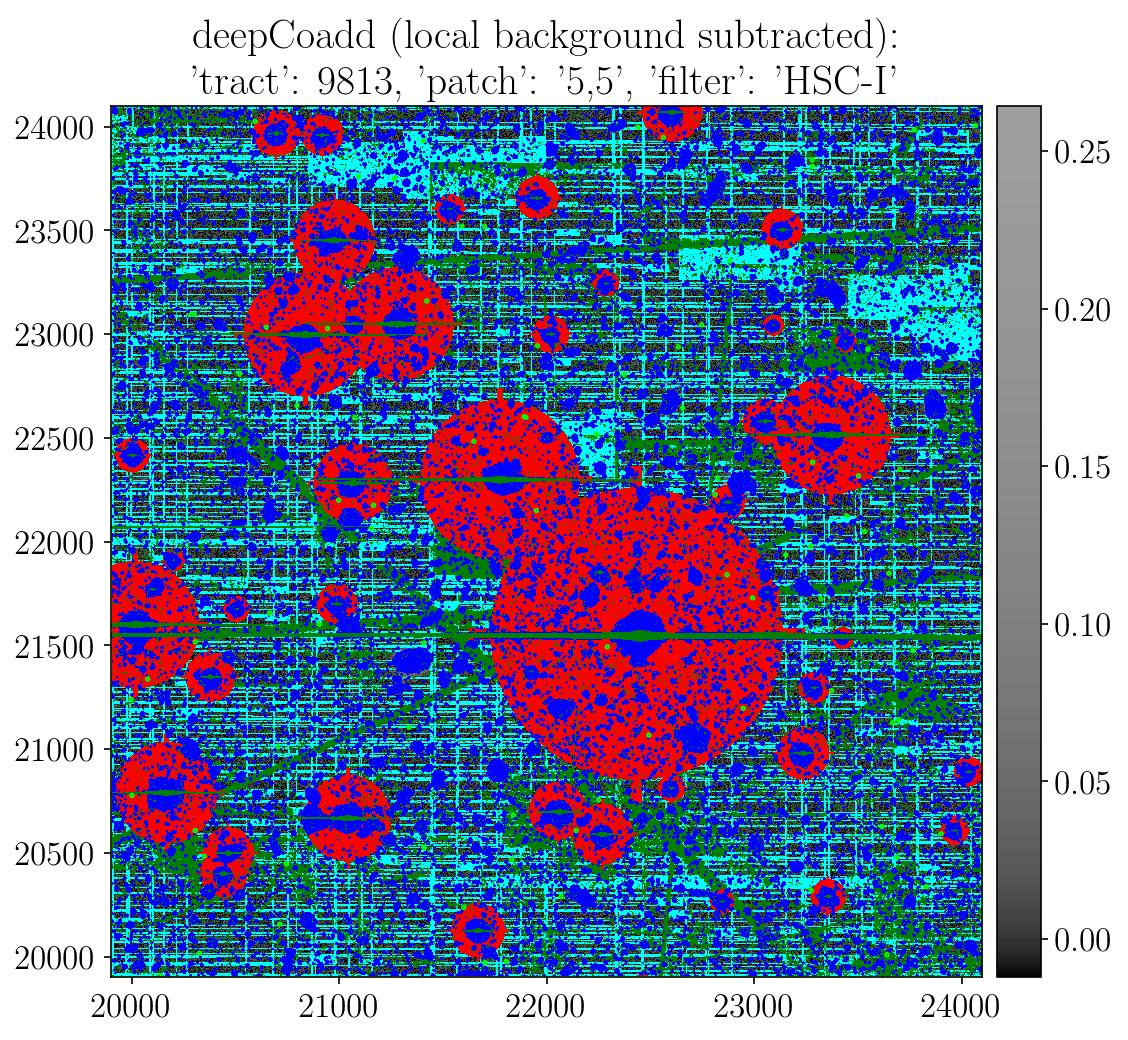

In [7]:
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
display.scale("asinh", np.quantile(coadd0.image.array, 0.2), np.quantile(coadd0.image.array, 0.8))
display.setMaskTransparency(0)
display.mtv(coadd0)
for s in skyObj0:
    display.dot("o", s.getX(), s.getY(), size=8, ctype='green')
plt.title('deepCoadd (local background subtracted):\n' + str(dataId))
display.close()

In [8]:
background = butler0.get('deepCoadd_calexp_background', dataId=dataId)

In [9]:
backIm = background.getImage()

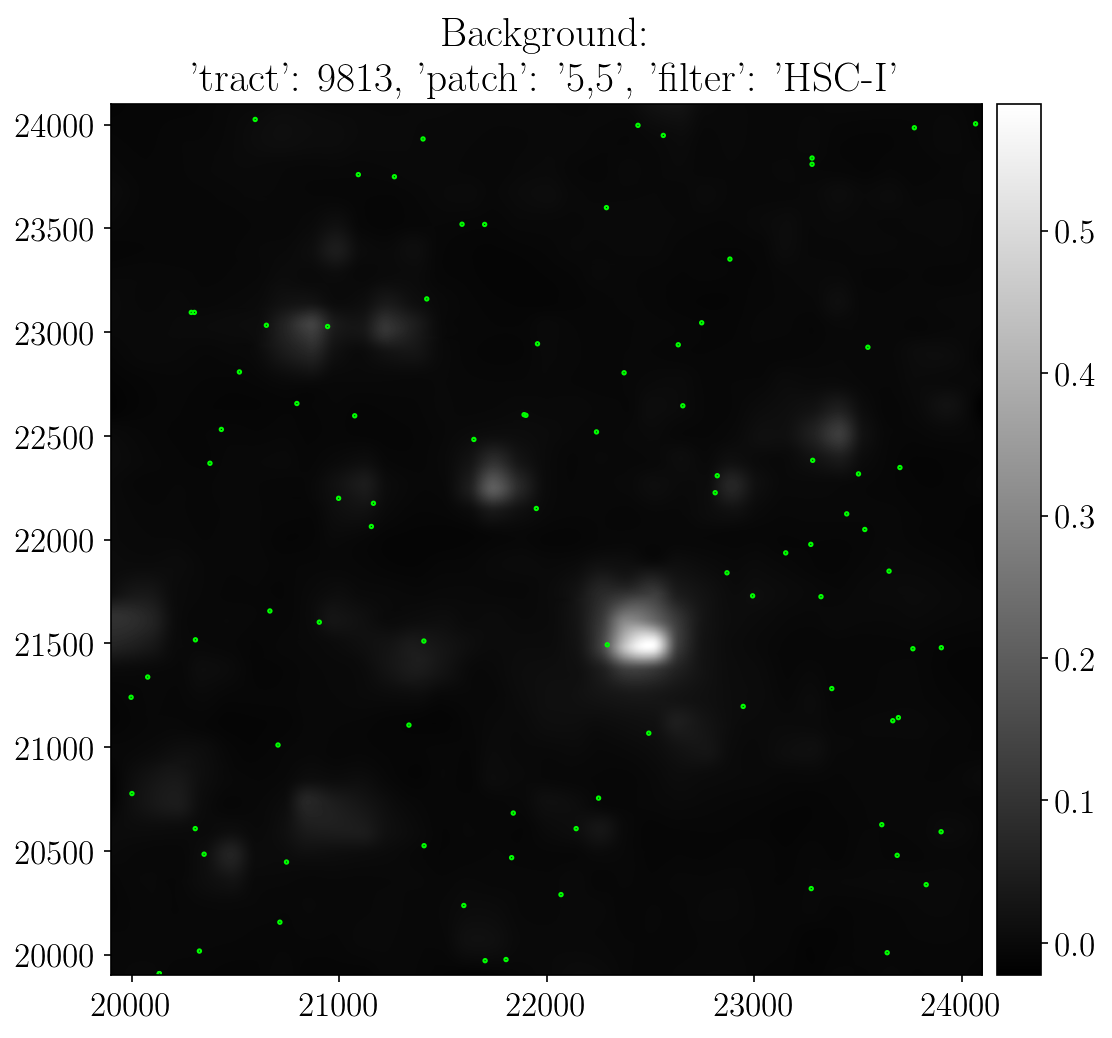

In [10]:
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
#display.scale("asinh", np.quantile(backIm.array, 0.2), np.quantile(backIm.array, 0.8))
display.setMaskTransparency(100)
display.mtv(backIm)
for s in skyObj0:
    display.dot("o", s.getX(), s.getY(), size=8, ctype='green')
plt.title('Background:\n' + str(dataId))
display.close()

In [11]:
mi = coadd1.clone().getMaskedImage()
mi += backIm

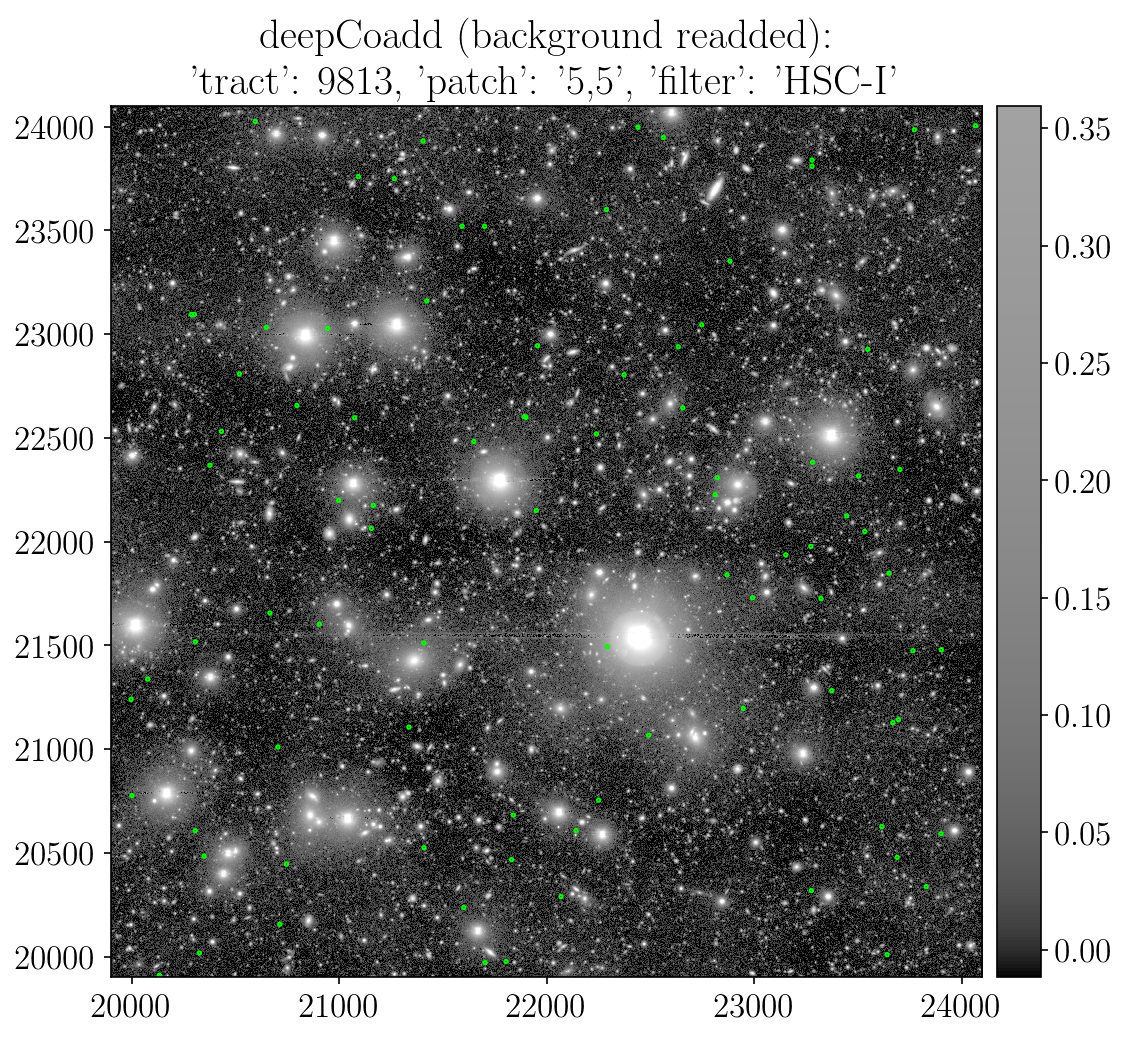

In [12]:
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
display.scale("asinh", np.quantile(mi.image.array, 0.2), np.quantile(mi.image.array, 0.8))
display.setMaskTransparency(100)
display.mtv(mi)
for s in skyObj0:
    display.dot("o", s.getX(), s.getY(), size=8, ctype='green')
plt.title('deepCoadd (background readded):\n' + str(dataId))
display.close()

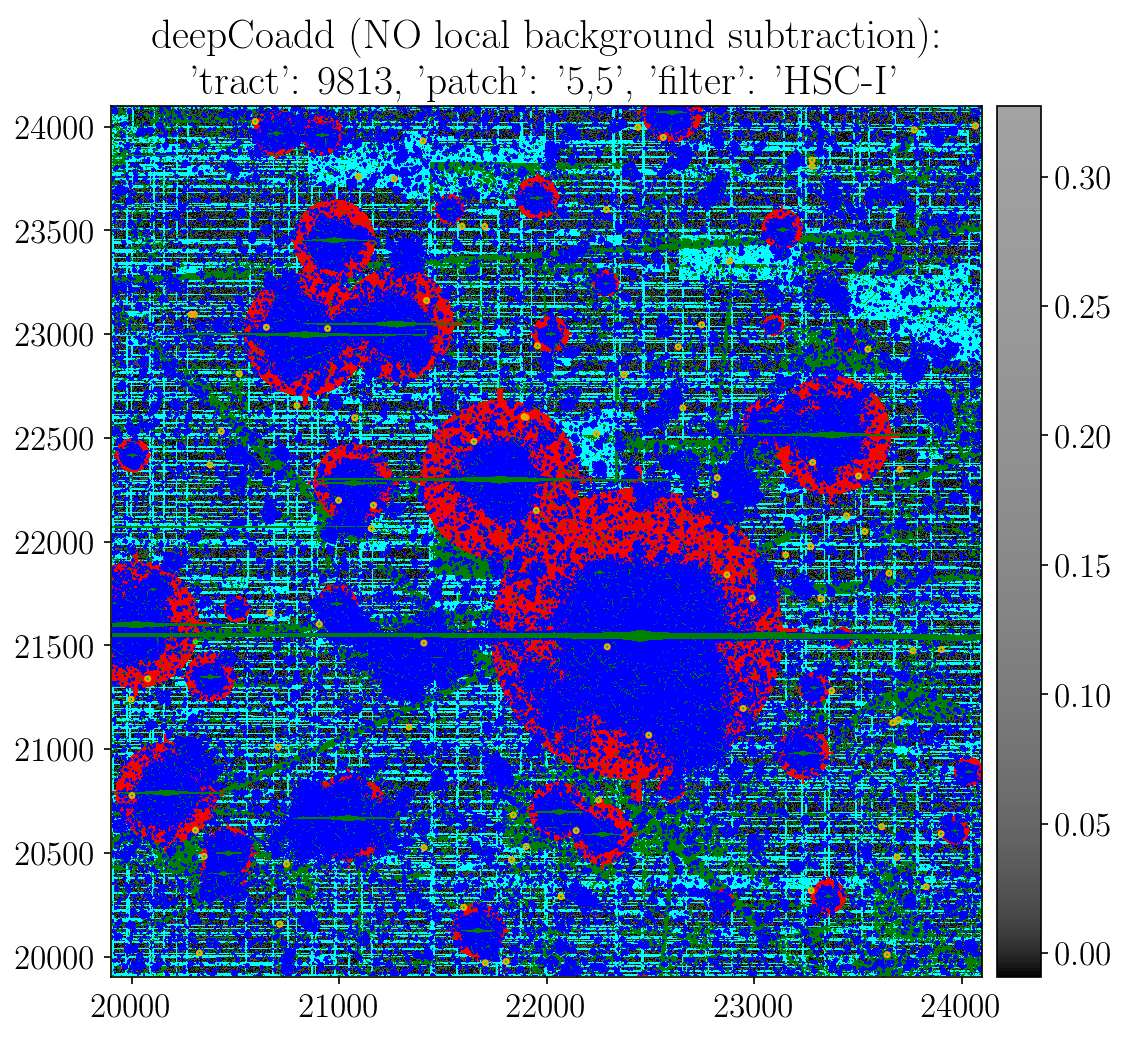

In [13]:
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
display.scale("asinh", np.quantile(coadd1.image.array, 0.2), np.quantile(coadd1.image.array, 0.8))
display.setMaskTransparency(0)
display.mtv(coadd1)
for s in skyObj0:
    display.dot("o", s.getX(), s.getY(), size=8, ctype='green')
for s in skyObj1:
    display.dot("o", s.getX(), s.getY(), size=12, ctype='orange')
plt.title('deepCoadd (NO local background subtraction):\n' + str(dataId))
display.close()

In [14]:
im0 = coadd0.image
im1 = coadd1.image

diff = im0.clone()
diff -= im1

print(np.max(im0.array), np.min(im0.array))
print(np.max(diff.array), np.min(diff.array))

126.17648 -0.54443914
1.1480789 -2.028633


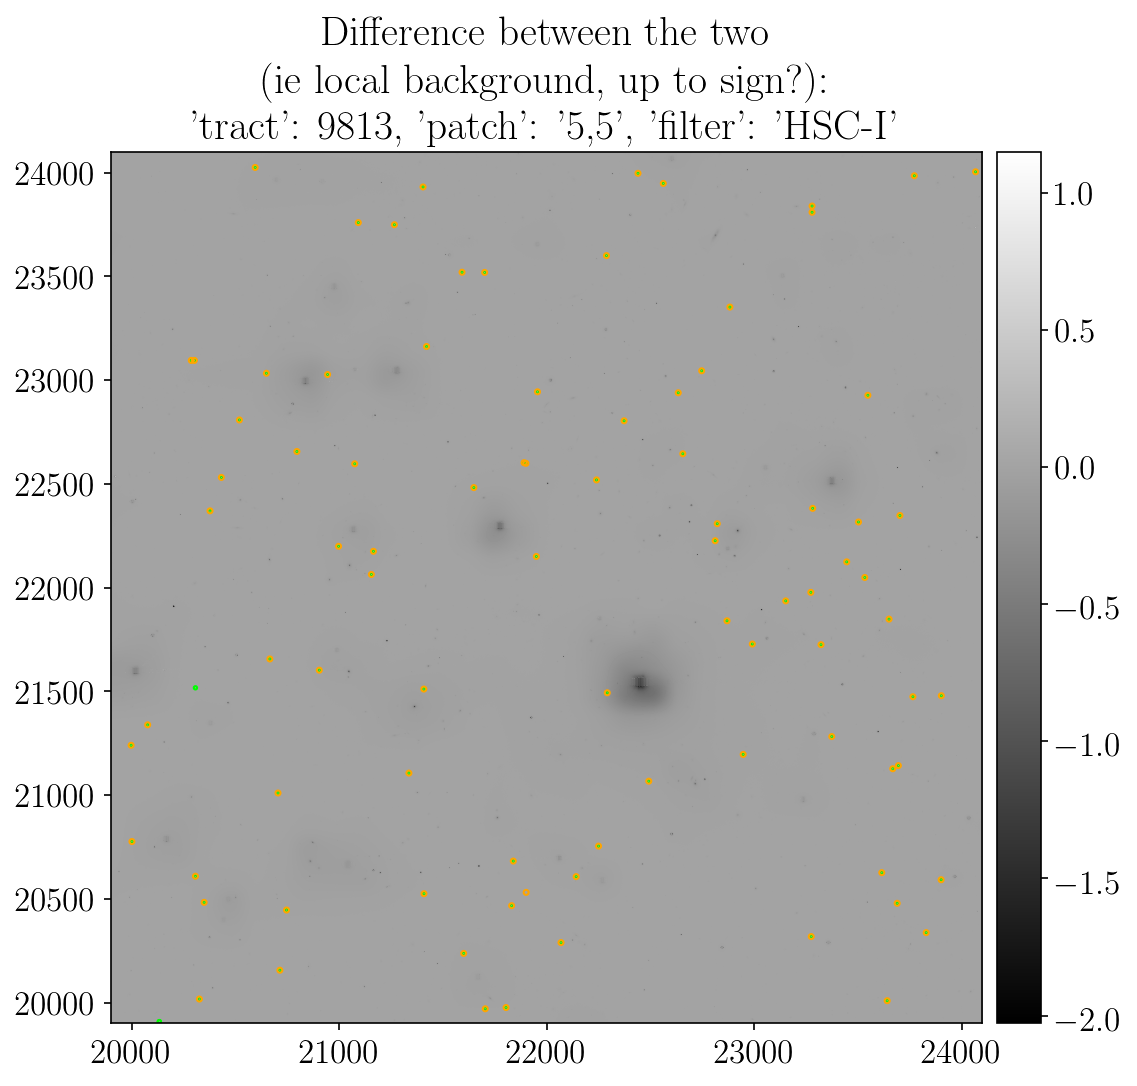

In [15]:
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
#display.scale("asinh", np.min(diff.array), np.max(diff.array))
display.setMaskTransparency(100)
display.mtv(diff)
for s in skyObj0:
    display.dot("o", s.getX(), s.getY(), size=8, ctype='green')
for s in skyObj1:
    display.dot("o", s.getX(), s.getY(), size=12, ctype='orange')
plt.title('Difference between the two\n(ie local background, up to sign?):\n' + str(dataId))
display.close()

## 2. Produce the plot

Select patches (and whether to throw away all flagged objects):

In [16]:
patches = ["5,5"]#["1,0", "2,0", "5,5"]
removeFlagged = True # remove all flagged objects

Compare positions of sky objects:

In [17]:
ra0 = skyObj0["coord_ra"]
dec0 = skyObj0["coord_dec"]

ra1 = skyObj1["coord_ra"]
dec1 = skyObj1["coord_dec"]

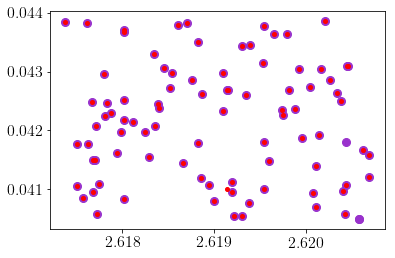

In [18]:
plt.plot(ra0, dec0, 'o', c='darkorchid')
plt.plot(ra1, dec1, '.', c='r')

Load measurements:

In [19]:
fluxes0, fluxes1 = [[] for _ in range(len(apRads))], [[] for _ in range(len(apRads))]

for patch in patches:
    dataId = {'tract': 9813, 'patch': patch, 'filter': 'HSC-I'}
    # load coadd measurements
    coaddMeas0 = butler0.get('deepCoadd_meas', dataId=dataId)
    coaddMeas1 = butler1.get('deepCoadd_meas', dataId=dataId)
    # extract sky objects
    skyObj0 = coaddMeas0[coaddMeas0['merge_peak_sky']]
    skyObj1 = coaddMeas1[coaddMeas1['merge_peak_sky']]
    print(f"Patch {patch}\t {len(skyObj0)}, {len(skyObj1)} sky objects w/ and w/o bgsub resp.")
    # load photoCalib to convert fluxes to nJy
    photoCalib0 = butler0.get("deepCoadd_calexp", dataId).getPhotoCalib()
    photoCalib1 = butler1.get("deepCoadd_calexp", dataId).getPhotoCalib()
    # convert and store fluxes
    for j, radius in enumerate(apRads):
        if radius==4.5:
            instFluxes0 = skyObj0['base_CircularApertureFlux_4_5_instFlux']
            instFluxes1 = skyObj1['base_CircularApertureFlux_4_5_instFlux']
            if removeFlagged:
                flag0 = ~skyObj0['base_CircularApertureFlux_4_5_flag']
                flag1 = ~skyObj1['base_CircularApertureFlux_4_5_flag']
                # replace flagged objects with nan
                instFluxes0[flag0] = np.nan
                instFluxes1[flag1] = np.nan
        else:
            instFluxes0 = np.copy(skyObj0['base_CircularApertureFlux_{}_0_instFlux'.format(radius)])
            instFluxes1 = np.copy(skyObj1['base_CircularApertureFlux_{}_0_instFlux'.format(radius)])
            if removeFlagged: 
                flag0 = ~skyObj0['base_CircularApertureFlux_{}_0_flag'.format(radius)]
                flag1 = ~skyObj1['base_CircularApertureFlux_{}_0_flag'.format(radius)]
                # replace flagged objects with nan
                instFluxes0[flag0] = np.nan
                instFluxes1[flag1] = np.nan
        # convert to nJy
        fluxes0[j].extend([photoCalib0.instFluxToNanojansky(flux) for flux in instFluxes0])
        fluxes1[j].extend([photoCalib1.instFluxToNanojansky(flux) for flux in instFluxes1])
fluxes0 = np.array(fluxes0).T
fluxes1 = np.array(fluxes1).T

print(fluxes0.size, fluxes0.size - np.sum(np.isnan(fluxes0)), fluxes0.shape)

Patch 5,5	 90, 88 sky objects w/ and w/o bgsub resp.
5220 3602 (90, 58)


### 21. Circular apertures

Compute per-pixel fluxes in each aperture:

In [20]:
apFlux0 = fluxes0 / areas
apFlux1 = fluxes1 / areas

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


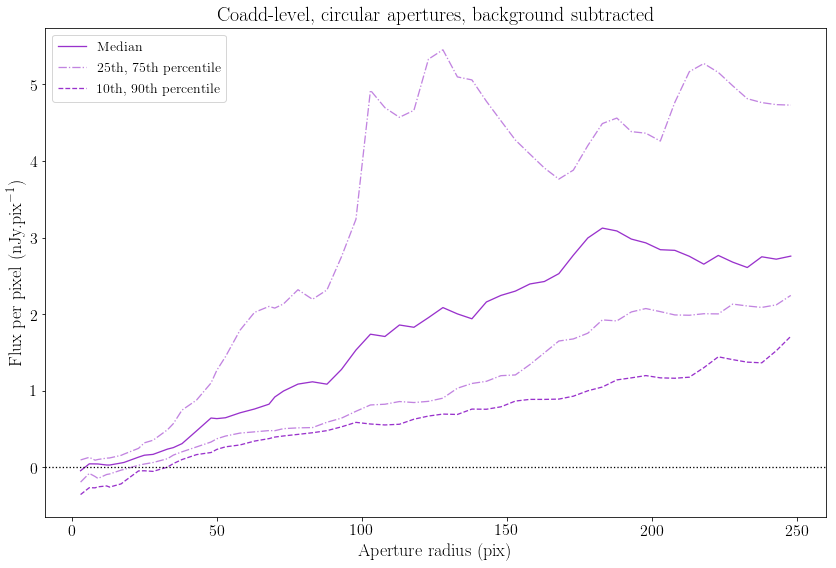

In [21]:
plt.rcParams['figure.figsize'] = 14, 9
plt.plot(apRads, np.nanmedian(apFlux0, axis=0), c='darkorchid', label='Median')
plt.plot(apRads, np.nanquantile(apFlux0, 0.25, axis=0), c='darkorchid', ls='-.', alpha=.6, 
         label='25th, 75th percentile')
plt.plot(apRads, np.nanquantile(apFlux0, 0.75, axis=0), c='darkorchid', ls='-.', alpha=.6)
plt.plot(apRads, np.nanquantile(apFlux0, 0.1, axis=0), c='darkorchid', ls='--', label='10th, 90th percentile')
#plt.plot(apRads, np.nanquantile(apFlux0, 0.9, axis=0), c='darkorchid', ls='--')
plt.legend()
plt.axhline(0, ls=":", c='k')
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.xlabel('Aperture radius (pix)')
plt.title('Coadd-level, circular apertures, background subtracted')
plt.show()

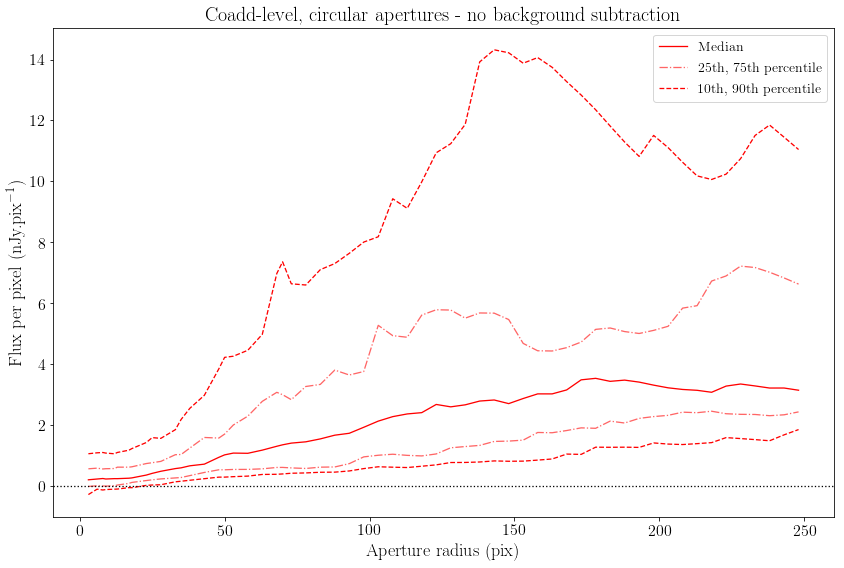

In [22]:
plt.rcParams['figure.figsize'] = 14, 9
plt.plot(apRads, np.nanmedian(apFlux1, axis=0), c='r', label= 'Median')
plt.plot(apRads, np.nanquantile(apFlux1, 0.25, axis=0), c='r', ls='-.', alpha=.6, 
         label='25th, 75th percentile')
plt.plot(apRads, np.nanquantile(apFlux1, 0.75, axis=0), c='r', ls='-.', alpha=.6)
plt.plot(apRads, np.nanquantile(apFlux1, 0.1, axis=0), c='r', ls='--')
plt.plot(apRads, np.nanquantile(apFlux1, 0.9, axis=0), c='r', ls='--', label='10th, 90th percentile')
plt.legend()
plt.axhline(0, ls=":", c='k')
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.xlabel('Aperture radius (pix)')
plt.title('Coadd-level, circular apertures - no background subtraction')
plt.show()

### 22. Annular appertures

In [23]:
anAreas = areas[1:] - areas[:-1]
print(anAreas)

[  84.82300165   87.9645943    53.40707511  197.92033718   78.53981634
  376.99111843  109.95574288  644.02649399  301.59289474  499.51323192
  958.18575934  427.25660089  688.00879114 1272.3450247  1429.42465738
  615.7521601   970.75212996 1743.58392274 1900.66355542 2057.7431881
  867.07957239 1347.74324839 2371.90245346 2528.98208614 2686.06171882
 2843.1413515  3000.22098418 3157.30061686 3314.38024954 3471.45988222
 3628.5395149  3785.61914758 3942.69878026 4099.77841293 4256.85804561
 4413.93767829 4571.01731097 4728.09694365 4885.17657633 5042.25620901
 5199.33584169 5356.41547437 5513.49510705 5670.57473973 5827.65437241
 5984.73400509 6141.81363777 6298.89327045 6455.97290313 6613.05253581
 6770.13216849 6927.21180117 7084.29143384 7241.37106652 7398.4506992
 7555.53033188 7712.60996456]


In [24]:
anFlux0 = fluxes0[:,1:] - fluxes0[:,:-1]
anFlux1 = fluxes1[:,1:] - fluxes1[:,:-1]

In [25]:
anFlux0 /= anAreas
anFlux1 /= anAreas

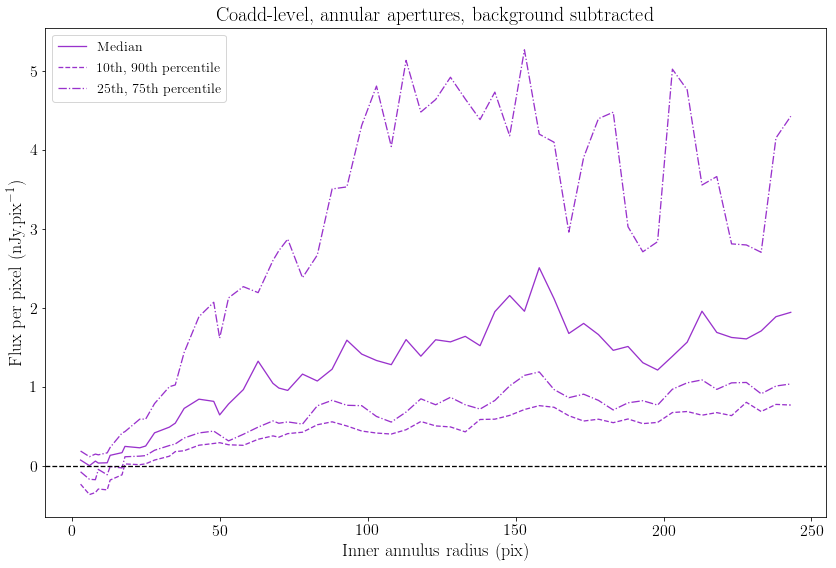

In [26]:
plt.plot(apRads[:-1], np.nanmedian(anFlux0, axis=0), c='darkorchid', label='Median')
plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.1, axis=0), c='darkorchid', ls="--", label='10th, 90th percentile')
#plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.9, axis=0), c='darkorchid', ls="--")
plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.25, axis=0), c='darkorchid', ls="-.", label='25th, 75th percentile', 
        )
plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.75, axis=0), c='darkorchid', ls="-.")
plt.axhline(0, c='k', ls="--")
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.title('Coadd-level, annular apertures, background subtracted')
plt.xlabel('Inner annulus radius (pix)')
plt.legend()
plt.show()

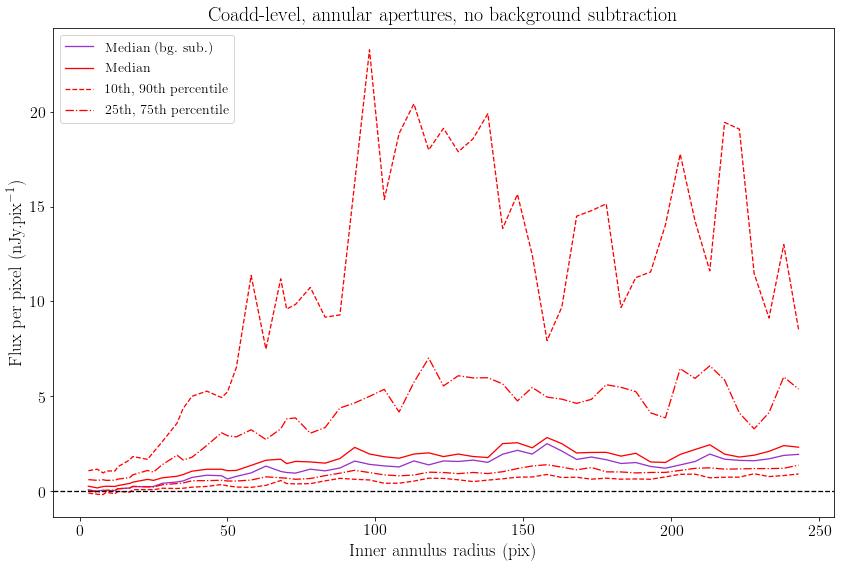

In [45]:
plt.plot(apRads[:-1], np.nanmedian(anFlux0, axis=0), c='darkorchid', label='Median (bg. sub.)')
plt.plot(apRads[:-1], np.nanmedian(anFlux1, axis=0), c='r', label='Median')
plt.plot(apRads[:-1], np.nanquantile(anFlux1, 0.1, axis=0), c='r', ls="--", label='10th, 90th percentile')
plt.plot(apRads[:-1], np.nanquantile(anFlux1, 0.9, axis=0), c='r', ls="--")
plt.plot(apRads[:-1], np.nanquantile(anFlux1, 0.25, axis=0), c='r', ls="-.", label='25th, 75th percentile')
plt.plot(apRads[:-1], np.nanquantile(anFlux1, 0.75, axis=0), c='r', ls="-.")
plt.axhline(0, c='k', ls="--")
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.title('Coadd-level, annular apertures, no background subtraction')
plt.xlabel('Inner annulus radius (pix)')
plt.legend()
plt.show()

## 3. Same at calexp level

In [28]:
butler = Butler('/project/mschmitz/hscRerun/YuanyuanRep_calexps')

In [29]:
visits = "1228^1230^1232^1238^1240^1242^1244^1246^1248^19658^19660^19662^19680^19682^19684^19694^19696^19698^19708^19710^19712^30482^30484^30486^30488^30490^30492^30494^30496^30498^30500^30502^30504".split("^")
visits = [int(visit) for visit in visits]
ccds = list(range(9)) + list(range(10,104))

Load measurements:

In [30]:
skySourceFlux = [[] for _ in range(len(apRads))]
for visit in visits:
    for ccd in ccds:
        calexpDataId = {'visit': visit, 'ccd': ccd}
        filename = butler.get('src_filename', dataId=calexpDataId)
        if os.path.exists(filename[0]):
            src = butler.get('src', dataId=calexpDataId)
            skySources = src[src['sky_source']]
            photoCalib = butler.get('calexp', dataId=calexpDataId).getPhotoCalib()
            for j, radius in enumerate(apRads):
                if radius==4.5:
                    instFluxes = skySources['base_CircularApertureFlux_4_5_instFlux']
                    if removeFlagged:
                        flag = ~skySources['base_CircularApertureFlux_4_5_flag']
                        # replace flagged objects with nan
                        instFluxes[flag] = np.nan
                else:
                    instFluxes = skySources['base_CircularApertureFlux_{}_0_instFlux'.format(radius)]
                    if removeFlagged:
                        flag = ~skySources['base_CircularApertureFlux_{}_0_flag'.format(radius)]
                        # replace flagged objects with nan
                        instFluxes[flag] = np.nan
                skySourceFlux[j].extend([photoCalib.instFluxToNanojansky(flux) for flux in instFluxes])
skySourceFlux = np.array(skySourceFlux).T
print(skySourceFlux.size, skySourceFlux.size - np.sum(np.isnan(skySourceFlux)))

8566600 6103532


### 31. Circular apertures

In [31]:
apFlux = skySourceFlux / areas

In [32]:
circMeds = np.nanmedian(apFlux, axis=0)
circ10 = np.nanquantile(apFlux, 0.1, axis=0)
circ90 = np.nanquantile(apFlux, 0.9, axis=0)
circ25 = np.nanquantile(apFlux, 0.25, axis=0)
circ75 = np.nanquantile(apFlux, 0.75, axis=0)

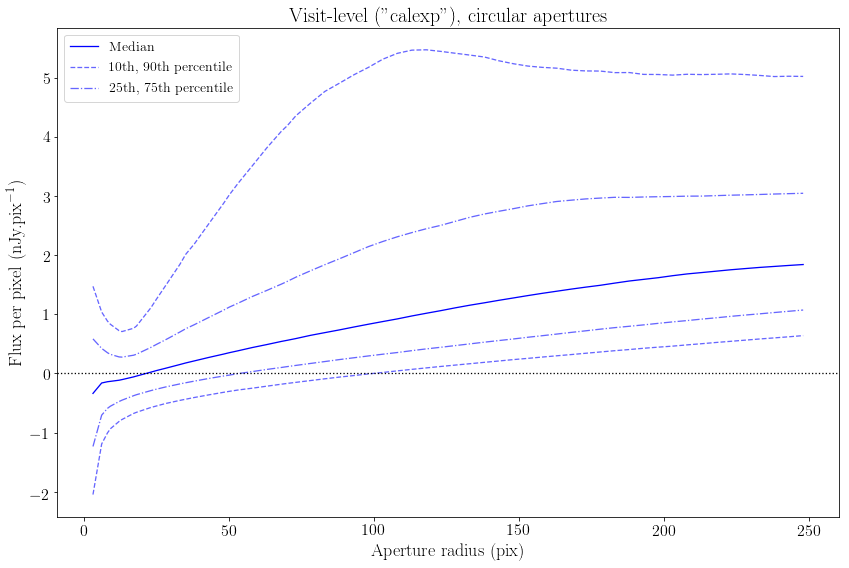

In [33]:
plt.rcParams['figure.figsize'] = 14, 9
plt.plot(apRads, circMeds, c='b', label='Median')
plt.plot(apRads, circ10, c='b', ls='--', alpha=.6, label='10th, 90th percentile')
plt.plot(apRads, circ90, c='b', ls='--', alpha=.6)
plt.plot(apRads, circ25, c='b', ls='-.', alpha=.6, label='25th, 75th percentile')
plt.plot(apRads, circ75, c='b', ls='-.', alpha=.6)
plt.title('Visit-level ("calexp"), circular apertures')
plt.axhline(0, ls=":", c='k')
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.xlabel('Aperture radius (pix)')
plt.legend()
plt.show()

### 32. Annular apertures

In [34]:
anFlux = skySourceFlux[:,1:] - skySourceFlux[:,:-1]
anFlux /= anAreas

In [35]:
annMed = np.nanmedian(anFlux, axis=0)
ann10 = np.nanquantile(anFlux, 0.1, axis=0)
ann90 = np.nanquantile(anFlux, 0.9, axis=0)
ann25 = np.nanquantile(anFlux, 0.25, axis=0)
ann75 = np.nanquantile(anFlux, 0.75, axis=0)

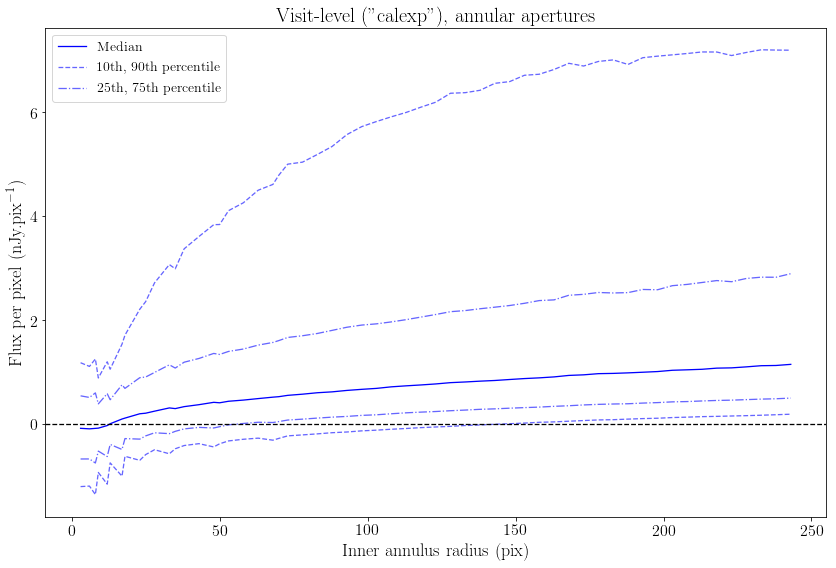

In [36]:
plt.plot(apRads[:-1], annMed, c='b', label='Median')
plt.plot(apRads[:-1], ann10, c='b', ls="--", alpha=.6, label='10th, 90th percentile')
plt.plot(apRads[:-1], ann90, c='b', ls="--", alpha=.6)
plt.plot(apRads[:-1], ann25, c='b', ls="-.", alpha=.6, label='25th, 75th percentile')
plt.plot(apRads[:-1], ann75, c='b', ls="-.", alpha=.6)
plt.axhline(0, c='k', ls="--")
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.xlabel('Inner annulus radius (pix)')
plt.title('Visit-level ("calexp"), annular apertures')
plt.legend()
plt.show()

In [37]:
print(annMed)

[-8.77015326e-02 -9.75387636e-02 -8.86582731e-02 -8.41522651e-02
 -3.45570775e-02  3.35306787e-04  9.18181883e-02  1.09377465e-01
  1.92875869e-01  2.03899794e-01  2.43093310e-01  3.05499407e-01
  2.92328360e-01  3.30289554e-01  3.67957316e-01  4.13362404e-01
  4.04469378e-01  4.33851261e-01  4.56390526e-01  4.85217927e-01
  5.12978290e-01  5.22213086e-01  5.47671511e-01  5.70332935e-01
  5.97988635e-01  6.15042037e-01  6.42761794e-01  6.63659873e-01
  6.82023416e-01  7.11797582e-01  7.31104196e-01  7.48106780e-01
  7.67619791e-01  7.92487031e-01  8.05628208e-01  8.21283280e-01
  8.34235706e-01  8.53138321e-01  8.71165897e-01  8.84873183e-01
  9.03229809e-01  9.31890482e-01  9.43132735e-01  9.65741354e-01
  9.70851152e-01  9.80988363e-01  9.93184261e-01  1.00635460e+00
  1.03093943e+00  1.04002396e+00  1.04996000e+00  1.07218634e+00
  1.07752131e+00  1.09674422e+00  1.11891054e+00  1.12333560e+00
  1.14484323e+00]


## 4. Using only default aperture radii
This section just answers a question Lee and I asked ourselves: can we get the slope about right, if we were to use only the default aperture radius values? TL;DR: no.


Recompute things using only default apertures:

In [38]:
KEEPONLY = 4
defApRads = [4.5, 6, 9, 12, 17, 25, 35, 50, 70][-KEEPONLY:]

In [39]:
deffluxes0 = [[] for _ in range(len(defApRads))]

for patch in patches:
    dataId = {'tract': 9813, 'patch': patch, 'filter': 'HSC-I'}
    # load coadd measurements
    coaddMeas0 = butler0.get('deepCoadd_meas', dataId=dataId)
    # extract sky objects
    skyObj0 = coaddMeas0[coaddMeas0['merge_peak_sky']]
    # load photoCalib to convert fluxes to nJy
    photoCalib0 = butler0.get("deepCoadd_calexp", dataId).getPhotoCalib()
    # convert and store fluxes
    for j, radius in enumerate(defApRads):
        if radius==4.5:
            instFluxes0 = np.copy(skyObj0['base_CircularApertureFlux_4_5_instFlux'])
            if removeFlagged:
                flag0 = ~skyObj0['base_CircularApertureFlux_4_5_flag']
                # replace flagged objects with nan
                instFluxes0[flag0] = np.nan
        else:
            instFluxes0 = np.copy(skyObj0['base_CircularApertureFlux_{}_0_instFlux'.format(radius)])
            if removeFlagged: 
                flag0 = ~skyObj0['base_CircularApertureFlux_{}_0_flag'.format(radius)]
                # replace flagged objects with nan
                instFluxes0[flag0] = np.nan
        # convert to nJy
        deffluxes0[j].extend([photoCalib0.instFluxToNanojansky(flux) for flux in instFluxes0])
deffluxes0 = np.array(deffluxes0).T

print(deffluxes0.size, deffluxes0.size - np.sum(np.isnan(deffluxes0)), deffluxes0.shape)

360 265 (90, 4)


In [40]:
defAnFlux0 = deffluxes0[:,1:] - deffluxes0[:,:-1]

In [41]:
defAreas = np.array([np.pi * (radius**2) for radius in defApRads])
defAnAreas = defAreas[1:] - defAreas[:-1]
print(defAnAreas)

[1884.95559215 4005.53063333 7539.82236862]


In [42]:
defAnFlux0 /= defAnAreas

In [43]:
allApsFit = np.polyfit(apRads[:-1], np.nanmedian(anFlux0, axis=0), 1)
defApsFit = np.polyfit(defApRads[:-1], np.nanmedian(defAnFlux0, axis=0), 1)
print(allApsFit)
print(defApsFit)

[0.00738822 0.36053302]
[ 0.02866476 -0.24731011]


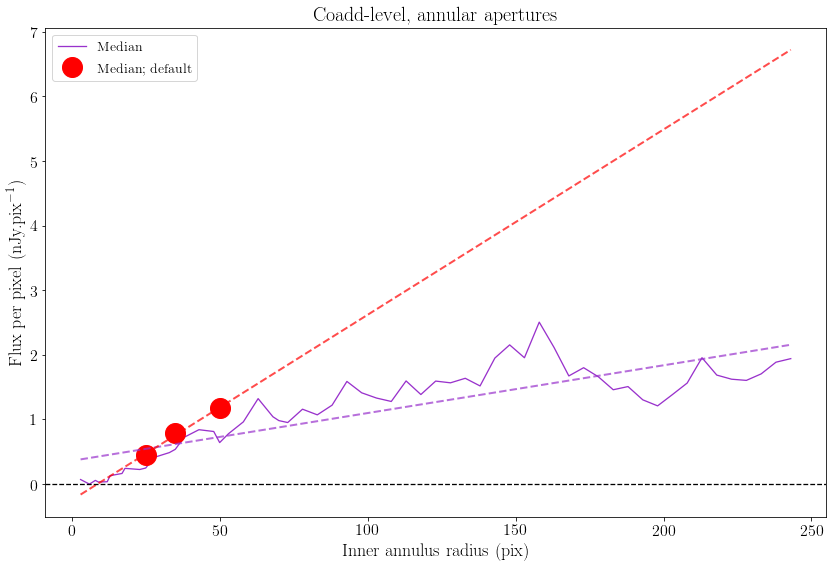

In [44]:
plt.plot(apRads[:-1], np.nanmedian(anFlux0, axis=0), c='darkorchid', label='Median')
plt.plot(defApRads[:-1], np.nanmedian(defAnFlux0, axis=0), 'o', c='r', label='Median; default', ms=20)


plt.plot(apRads[:-1], apRads[:-1]*allApsFit[0] + allApsFit[1], c='darkorchid', ls='--', lw=2, alpha=.7)
plt.plot(apRads[:-1], apRads[:-1]*defApsFit[0] + defApsFit[1], c='red', ls='--', lw=2, alpha=.7)
#plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.1, axis=0), c='darkorchid', ls="--", label='10th, 90th percentile')
#plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.9, axis=0), c='darkorchid', ls="--")
#plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.25, axis=0), c='darkorchid', ls="-.", label='25th, 75th percentile', 
#        )
#plt.plot(defApRads[:-1], np.nanquantile(defAnFlux0, 0.25, axis=0), c='r', ls="-.")
#plt.plot(apRads[:-1], np.nanquantile(anFlux0, 0.75, axis=0), c='darkorchid', ls="-.")
#plt.plot(defApRads[:-1], np.nanquantile(defAnFlux0, 0.75, axis=0), c='r', ls="-.")
plt.axhline(0, c='k', ls="--")
plt.ylabel(r'Flux per pixel (nJy.pix$^{-1}$)')
plt.title('Coadd-level, annular apertures ')
plt.xlabel('Inner annulus radius (pix)')
plt.legend()
plt.show()